In [1]:
import torch
torch.cuda.is_available()

True

## Load yolov7 to obtain keypoints

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
import time
from torch.utils.data import Dataset, DataLoader


from torchvision import transforms
from PIL import Image


In [3]:
# Change directory to "/yolov7"
os.chdir("yolov7")
print(os.getcwd()) 


###############################################################################

# Move one directory up
# os.chdir(os.path.dirname(os.getcwd()))
# print(os.getcwd()) 

/notebooks/Fighting-detection-in-CCTVs/yolov7


In [4]:
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


###############################################################################

# Load yolov7 pose detector model
print("Loading model: ", "yolov7-pose...")
weights_path = "yolov7-w6-pose.pt"
model_yolov7 = torch.load(weights_path, map_location=device, weights_only=False)['model']
print("Model loaded.")

model_yolov7.float().eval()

if torch.cuda.is_available():
    # half() turns predictions into float16 tensors --> significantly lowers inference time
    model_yolov7.half().to(device)

Loading model:  yolov7-pose...
Model loaded.


## Image inference code for testing

In [5]:

# Main inference
def infer(image):
    image = letterbox(image, 960, 
                      stride=64,
                      auto=True)[0]  # shape: (567, 960, 3)
    
    image = transforms.ToTensor()(image)  # torch.Size([3, 567, 960])

    if torch.cuda.is_available():
        image = image.half().to(device)

    image = image.unsqueeze(0)  # torch.Size([1, 3, 567, 960])

    with torch.no_grad():
        output, _ = model_yolov7(image)

    return output, image


###############################################################################

# Draw YOLOv7 pose keypoints and optionally return keypoints for saving.
def draw_keypoints(output, image, confidence=0.25, threshold=0.65, return_kpts=True):
    output = non_max_suppression_kpt(
        output,
        confidence,
        threshold,
        nc=model_yolov7.yaml['nc'],
        nkpt=model_yolov7.yaml['nkpt'],
        kpt_label=True)

    with torch.no_grad():
        # shape: (num_people, 51)
        output = output_to_keypoint(output)  

    # Convert tensor image back to numpy
    nimg = image[0].permute(1, 2, 0) * 255
    nimg = cv2.cvtColor(nimg.cpu().numpy().astype(np.uint8), cv2.COLOR_RGB2BGR)

    # Correctly loop through 'output' variable instead of 'kpts'
    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

    if return_kpts:
        # (image with keypoints drawn, raw keypoints)
        return nimg, output  

    return nimg


## Create custom dataloader
- includes pre-processing via yolov7 pose estimator

In [19]:

class VideoDataset(Dataset):
    def __init__(self, video_files, video_folder, sequence_len=24):
        self.video_folder = video_folder
        self.video_files = video_files
        self.sequence_len = sequence_len
        self.data = self._load_data()

    
    
    def _load_data(self):
        data = []
        
        for video_file in self.video_files:
            video_path = os.path.join(self.video_folder, video_file)
            # if the video name is "nofixxx.mp4", this means no-fight --> 0
            # if "NV_xx.mp4" means no-fight
            if "nofi" in video_file or "NV" in video_file:
                label = 0
            else:
                label = 1
                                      
            capture = cv2.VideoCapture(video_path)
            fps = int(capture.get(cv2.CAP_PROP_FPS))
            total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
             
            frames = []
            # for idx in range(0, total_frames, fps): # use this to sample one frame per second
            for idx in range(0, total_frames, 2): # use this to sample all frames in the video
                capture.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = capture.read()
                if ret:
                    try:
                        # Process the frame
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        output, image_tensor = infer(frame_rgb)
                        _, keypoints = draw_keypoints(output, image_tensor, return_kpts=True)

                        if keypoints is not None and keypoints.shape[0] > 0:
                            # Only the 17 keypoints
                            first_person_kpts = keypoints[0, 7:]  
                            # Shape: (17, 3)
                            keypoints = first_person_kpts.reshape(-1, 3)  

                        else:
                            # Pad with zeros if no keypoints
                            keypoints = np.zeros((17, 3)) 

                        # Keep the frames in sequence of length --> required for LSTM
                        frames.append(keypoints)

                        # We only want the keypoints in numpy version and labels
                        if len(frames) == self.sequence_len:
                            data.append((np.array(frames), label))
                            frames = []
                            
                    except cv2.error as e:
                        # If there are errors, skip it
                        print(f"Error processing frame: {e}")
                        continue
                        
            capture.release()
        return data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        keypoints, label = self.data[idx]
        # Convert to pytorch from numpy
        keypoints = torch.from_numpy(keypoints).float()
        # Flatten (17, 3) to (51)
        keypoints = keypoints.view(self.sequence_len, -1) 
        return keypoints, label


In [88]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

print("Preparing dataloaders...")

video_folder = "../fight-detection-4"
video_files = [f for f in os.listdir(video_folder) if f.endswith((".mp4", ".avi", ".mov", ".mpeg"))]


###############################################################################

print("Splitting data...")
# Split dataset such that 20% of data is used for testing, remaining 80% for training + validation
train_files, test_files = train_test_split(video_files, test_size=0.2, random_state=42)
# Split dataset such that 60% of data is used for training, remaining 20% for validation
train_files, val_files = train_test_split(train_files, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

###############################################################################

train_dataset = VideoDataset(train_files, video_folder)
print("Train dataset compiled...")
val_dataset = VideoDataset(val_files, video_folder)
print("Validation dataset compiled...")
test_dataset = VideoDataset(test_files, video_folder)
print("Test dataset compiled...")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print("Train dataloader compiled...")        
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print("Validation dataloader compiled...")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Test dataloader compiled...")



Preparing dataloaders...
Splitting data...
Train dataset compiled...
Validation dataset compiled...
Test dataset compiled...
Train dataloader compiled...
Validation dataloader compiled...
Test dataloader compiled...


## Previous dataloader
- where each video is processed with their own skeletal points in numpy array
- to be saved in a numpy file
- this dataloader groups the corresponding adjacent files together
- but due to memory concerns, this dataloader has been changed

In [ ]:
from torch.utils.data import Dataset
import os
import numpy as np
import torch

# String together the related keyframes into a sequence for learning
class PoseSequenceDataset(Dataset):
    def __init__(self, frame_dir, sequence_len=30, label=1):  # <-- This line is important
        self.frame_dir = frame_dir
        self.sequence_len = sequence_len
        self.label = label

        # Sort all keypoint files
        self.keypoint_files = sorted([
            os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith('.npy')
        ])

        # Create sequences
        self.sequences = [
            self.keypoint_files[i:i+sequence_len]
            for i in range(0, len(self.keypoint_files) - sequence_len + 1, sequence_len)
        ]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence_paths = self.sequences[idx]
        # (seq_len, 17, 2)
        sequence = np.array([np.load(p)[:, :2] for p in sequence_paths])  
        # (seq_len, 34)
        sequence = sequence.reshape(self.sequence_len, -1)  
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(self.label, dtype=torch.long)


### Create pytorch instance of (vanilla) LSTM

In [8]:
import torch.nn as nn

class FightClassifierLSTM(nn.Module):
    def __init__(self, input_size=51, hidden_size=64, num_layers=2, num_classes=1):
        super(FightClassifierLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)  
        # Use last time step
        out = out[:, -1, :] 
        # Output logits --> to be used with sigmoid or torch.max() later on
        out = self.fc(out)     
        return out
    
###############################################################################

model_lstm = FightClassifierLSTM()
model_lstm.to(device)

FightClassifierLSTM(
  (lstm): LSTM(51, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

## Train LSTM on fighting and non-fighting datasets
- lr = 0.001
- epochs = 100
- Adam optimiser

In [89]:
# Load any previous saved epochs for further fine tuning
model_lstm.load_state_dict(torch.load('../model_epoch_recent_lstm_data4.pth'))

<All keys matched successfully>

In [90]:
def validate(model, val_loader):
    # Set the model to evaluation mode
    model.eval()  
    val_loss = 0.0
    correct, total = 0, 0
    # Ensure the same loss function is used as training code
    criterion = nn.BCEWithLogitsLoss()  

    # Disable gradient computation
    with torch.no_grad():  
        # Load the datasets from the validation pile
        for keypoints, labels in val_loader:
            keypoints, labels = keypoints.to(device), labels.to(device).float()
            # Model inference
            outputs = model(keypoints)
            
            # Accumulate the loss
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * keypoints.size(0)  
            
            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted.cpu() == labels.cpu().unsqueeze(1)).sum().item()

    # Compute the average loss
    val_loss /= len(val_loader.dataset)  
    val_accuracy = correct / total
    return val_loss, val_accuracy

###############################################################################

num_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define loss function and optimiser
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model_lstm.fc.parameters(), lr=0.0001)

# For debugging
count = 1

###############################################################################

for epoch in range(num_epochs):
    model_lstm.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    for keypoints, labels in train_loader:
        inputs, labels = keypoints.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu().unsqueeze(1)).sum().item()
        
        # For debugging - checking the contrast between predicted values and true labels
        if count >= 0:
            print(f"Predicted value: {predicted.cpu()}")
            print(f"Label: {labels.cpu().unsqueeze(1)}")
            count -= 1

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation step
    val_loss, val_accuracy = validate(model_lstm, val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Save model weights for every 5 epochs
    # if epoch % 5 == 0:
    #     torch.save(model_lstm.state_dict(), f'../model_lstm_epoch_{epoch+1}.pth')

Predicted value: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]], grad_fn=<ToCopyBackward0>)
Label: tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.]])
Predicted value: tensor([[0.],
        [1.],
      

## Save model weights

In [91]:
torch.save(model_lstm.state_dict(), f'../model_epoch_recent_lstm_data4.pth')

## Show training-val loss and accuracy over epochs

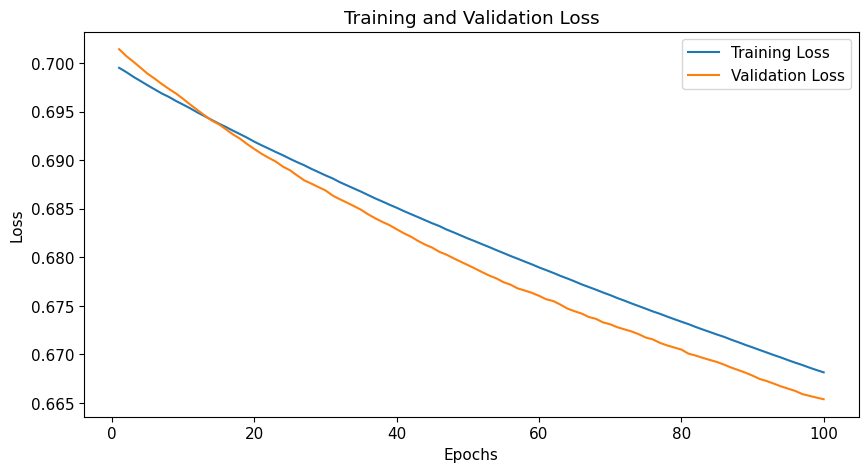

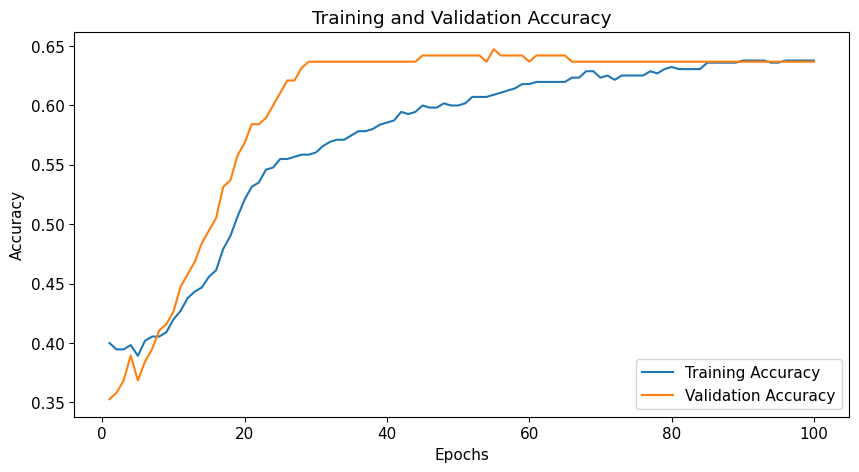

In [92]:
%matplotlib inline

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


## Testloader
- can be used for unseen dataset
- or for the 20% split dataset done earlier

In [21]:
# Load weights
model_lstm.load_state_dict(torch.load('../model_epoch_recent_lstm_data4.pth'))

###############################################################################

# Use the Dataloader for unseen dataset
print("Preparing test dataloader...")

video_folder = "../fight-detection-small"
video_files = [f for f in os.listdir(video_folder) if f.endswith((".mp4", ".avi", ".mov", ".mpeg"))]

test_dataset = VideoDataset(video_files, video_folder)
print("Test dataset compiled...")

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Test dataloader compiled...")

###############################################################################

# Set up the testing function
def test(model, test_loader=test_loader):
    # Set the model to evaluation mode
    model.eval()  
    test_loss = 0.0
    correct, total = 0, 0
    
    # Ensure the same loss function is used
    criterion = nn.BCEWithLogitsLoss()  

    # Disable gradient computation
    with torch.no_grad():  
        for keypoints, labels in test_loader:
            keypoints, labels = keypoints.to(device), labels.to(device).float()
            # Model inference
            outputs = model(keypoints)
            predicted = torch.round(torch.sigmoid(outputs))
            # Chose this if custom threshold is needed
            # threshold = 0.3
            # predicted = (outputs > threshold).float()

            
            # Accumulate the loss
            loss = criterion(outputs, labels.unsqueeze(1))
            test_loss += loss.item() * keypoints.size(0)  
            
            # Calculate accuracy
            total += labels.size(0)
            correct += (predicted.cpu() == labels.cpu().unsqueeze(1)).sum().item()

    # Compute the average loss
    test_loss /= len(test_loader.dataset)  
    test_accuracy = correct / total
    return test_loss, test_accuracy

###############################################################################

# Call the test function and test it via the the test_loader
test_loss, test_accuracy = test(model_lstm)
print(f"Test loss: {test_loss} Test accuracy: {test_accuracy}")

Preparing test dataloader...
Test dataset compiled...
Test dataloader compiled...
Test loss: 0.7012654657233252 Test accuracy: 0.4383561643835616


## Basic inference and testing - for one video file

In [33]:
# Load weights
model_lstm.load_state_dict(torch.load('../model_epoch_recent_lstm_data4.pth'))
model_lstm.eval()

###############################################################################

# Pre-process input --> extract frames
# video_path = '../fight-detection-2/V80.mp4'
video_path = '../fight-0002.mpeg'

########################################################4#######################

class Video(Dataset):
    def __init__(self, video_path, sequence_len=24):
        self.video_path = video_path
        self.sequence_len = sequence_len
        self.data = self._load_data()

    def _load_data(self):
        data = []
                                            
        capture = cv2.VideoCapture(video_path)
        fps = int(capture.get(cv2.CAP_PROP_FPS))
        total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
             
        frames = []
        # for idx in range(0, total_frames, fps): # use this to sample one frame per second
        for idx in range(0, total_frames, 2): # use this to sample *most* frames in the video
            # Try to process frames
            try:
                capture.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = capture.read()
                if ret:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    output, image_tensor = infer(frame_rgb)
                    _, keypoints = draw_keypoints(output, image_tensor, return_kpts=True)

                    if keypoints is not None and keypoints.shape[0] > 0:
                        # Only the 17 keypoints
                        first_person_kpts = keypoints[0, 7:]  
                        # Shape: (17, 3)
                        keypoints = first_person_kpts.reshape(-1, 3)  

                    else:
                        # Pad with zeros if no keypoints
                        keypoints = np.zeros((17, 3)) 

                    # Keep the frames in sequence of length
                    frames.append(keypoints)
                    print(f"length of frames: {len(frames)}")

                    # We only want the keypoints in numpy version and labels
                    if len(frames) == self.sequence_len:
                        data.append(np.array(frames))
                        frames = []
                        
            # If there are errors, skip it
            except cv2.error as e:
                print(f"Error processing frame: {e}")
                continue
                    
            capture.release()
        return data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        keypoints, label = self.data[idx]
        # Convert to torch from numpy
        keypoints = torch.from_numpy(keypoints).float()
        # Flatten (17, 3) to (51)
        keypoints = keypoints.view(self.sequence_len, -1) 
        return keypoints, label

###############################################################################

processed_video = Video(video_path)
print("Video compiled.")

num_processed_frames = len(processed_video)
if num_processed_frames == 0:
    print("Video is too short to process or there is not enough footage with a person in it.")
    print("Video resolution could also be poor that no pose is estimated :(")

else:
    video_loader = DataLoader(processed_video, batch_size=32, shuffle=False)     
    print("Video loaded, proceeding to inferencing.")

###############################################################################
        
    # inference
    for index, keypoints in enumerate(video_loader):
        keypoints = keypoints.to(device)
        outputs = model_lstm(keypoints)
        predicted = torch.round(torch.sigmoid(outputs))
        print(f"Predicted result for batch {index+1}: {predicted}")

Video compiled.
Video is too short to process or there is not enough footage with a person in it.
Video resolution could also be poor that no pose is estimated :(
